Columnwise estimation method for inverse Cov
---------------------------------------------

* The idea:

    Ax_k = e_k ->  x_k = A^(-1)e_k

    Solve x_k for k = 1, ..., n in parallel

* Thoughts

    Pitäisi olla yksikäsitteinen ratk, koska n tuntematonta ja n yhtälöä

* Another version
    * not columnwise, but take blocks of the identity matrix such that they contain several columns - > solving should give the respective columns of the inverse

About opening the datasets
---------------------------

* If you don't explicitly specify the chunks parameter in xr.open_dataset(), the resulting dataset won't consist of dask arrays -> it won't be lazy


In [16]:
# imports

import numpy as np
import xarray as xr
import scipy.sparse.linalg 
import dask
from dask.distributed import Client, progress
from dask import delayed
import dask.array as da
from functools import partial




invm = np.linalg.inv
gmres = scipy.sparse.linalg.gmres

ds_1 = xr.open_dataset("data/regions_verify_isotope_202112_cov.nc", chunks = 'auto')
bio_1 = ds_1["covariance_bio"]
anth_1 = ds_1["covariance_anth"]

ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc", chunks = 'auto')
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

#M = bio_2.values


In [6]:
ds_2

<xarray.Dataset>
Dimensions:           (nparams_bio: 6858, nparams_anth: 6858,
                       nparams_anth2: 6858)
Coordinates:
  * nparams_bio       (nparams_bio) int64 0 1 2 3 4 ... 6853 6854 6855 6856 6857
  * nparams_anth      (nparams_anth) int64 0 1 2 3 4 ... 6854 6855 6856 6857
  * nparams_anth2     (nparams_anth2) int64 0 1 2 3 4 ... 6854 6855 6856 6857
Data variables:
    covariance_bio    (nparams_bio, nparams_bio) float64 dask.array<chunksize=(4096, 6858), meta=np.ndarray>
    covariance_anth   (nparams_anth, nparams_anth) float64 dask.array<chunksize=(4096, 6858), meta=np.ndarray>
    covariance_anth2  (nparams_anth2, nparams_anth2) float64 dask.array<chunksize=(4096, 6858), meta=np.ndarray>

In [8]:
bio_2.data

dask.array<open_dataset-48c3b7c0b2421045a23b046e6be18d77covariance_bio, shape=(6858, 6858), dtype=float64, chunksize=(4096, 6858), chunktype=numpy.ndarray>

In [2]:
invM_real = invm(M)


The whole inverse matrix
------------------------

When parallelizing this, we need to take into account the fact that the columns need to be assembled in the correct order after they have been computed

Multiprocessing
------------------


Note: in documentation they say that with long iterables, a much better performance can be achieved by using imap() or imap_unordered() with a chunksize > 1 instead of map()

[[1 1]
 [2 2]]
[1 1]


In [17]:
M = bio_1.values

In [14]:
import multiprocessing as mp
#as many processes as there are CPUs available
nprocesses = mp.cpu_count()
pool = mp.Pool(processes = nprocesses)

def write_to_file(M, iM, exit_codes, filename):
    out = xr.Dataset()
    out["cov"] = (('nstate', 'nstate'), M)
    out["invcov"] = (('nstate', 'nstate'), iM)
    out["exit_codes"] = ('nstate', list(exit_codes))
    out.to_netcdf(f"{filename}.nc")
    



def parallel_gmres(M, tol=1e-8):
    n = len(M)
    #this might be possible to be done with only creating each std unit vector
    eye = np.eye(n)
    icols_exitvals = pool.starmap(gmres, [(M, col, None, tol) for col in eye])

    return icols_exitvals



icols_exitvals = parallel_gmres(M)

#split inverted columns and exits to two tuples
icols, exits = zip(*icols_exitvals)
#stack the columns into matrix form
iM = np.stack(icols, axis = 1)

write_to_file(M, iM, exits, "testcol1")




In [15]:
output = xr.open_dataset("testcol1.nc")
output

<xarray.Dataset>
Dimensions:    (nstate: 41)
Dimensions without coordinates: nstate
Data variables:
    cov        (nstate, nstate) float64 ...
    invcov     (nstate, nstate) float64 ...
    converged  (nstate) int64 ...

In [11]:
list(exits)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [6]:
iM.shape

(41, 41)

Splitting the result into icols and exits and forming the inv matrix
---------------------------------------------------------------------
Note: These can probably be parallelized, too.

In [28]:
icols, exits = zip(*icolsexits)
iM = np.stack(icols, axis = 1)
print(iM)

[[ 1.25426569e+00 -3.52374857e-02 -6.35396432e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.52374850e-02  1.25182439e+00 -1.33715850e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.35396421e-02 -1.33715845e-02  1.26289885e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.00079700e+00
  -6.31019841e-02  4.64502611e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.31019842e-02
   5.00079671e+00 -2.09464749e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.61261474e-07
  -2.09426619e-05  5.00489954e+00]]


In [7]:
print(iM)

[(array([ 1.25426569e+00, -3.52376307e-02, -6.35396110e-02, -1.01307584e-03,
       -1.00271373e-03, -2.94141587e-05,  6.41042419e-06, -2.94244791e-09,
       -2.06605347e-10, -2.81243110e-11, -1.28292003e-08, -4.76777337e-09,
       -1.27486086e-09, -6.11404789e-12, -3.45913291e-05, -8.87014102e-04,
       -1.44639298e-08, -3.28337778e-08, -1.03916314e-07,  2.50712264e-10,
       -1.29948256e-09, -1.65996080e-11, -1.75209238e-05,  8.39790891e-08,
       -2.42543621e-07, -1.48728945e-07,  8.97348749e-08, -5.26137330e-07,
       -1.12553241e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00]), 0), (array([-3.52370181e-02,  1.25182439e+00, -1.33741400e-02, -2.83915234e-02,
       -1.60969329e-04, -1.67185965e-04, -1.05825953e-05,  5.34857381e-08,
       -4.31696893e-10, -4.55222154e-11, -1.31614082e-07, -2.840409

Dask
-----


In [18]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38223,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.78 GiB
Comm: tcp://127.0.0.1:39973,Total threads: 2
Dashboard: http://127.0.0.1:37509/status,Memory: 7.69 GiB
Nanny: tcp://127.0.0.1:33373,


In [26]:
client.shutdown()

2022-11-30 17:30:26,531 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


Dask delayed
--------------
* just trying out if it works
* worked with the smaller matrix, but with the bigger one memory seems to be an issue
* persisting bio_2.data seems to have worked: the reading of the data happened only once in the beginning of the process
* Also all workers seem to have equal amount of work
* The problem is that execution was very slow

Below the version that in .py file also

In [24]:

import numpy as np
import xarray as xr
from scipy.sparse.linalg import gmres
import dask


def write_to_file(M, iM, exit_codes, filename):
    out = xr.Dataset()
    out["cov"] = (('nstate', 'nstate'), M)
    out["invcov"] = (('nstate', 'nstate'), iM)
    out["exit_codes"] = ('nstate', list(exit_codes))
    out.to_netcdf(f"./{filename}.nc")

def colinv(M):
    n = len(M)
    cols = []
    exit_codes = []

    for i in np.arange(n):
        e_i = np.zeros(n)
        e_i[i] = 1
        inv_col = dask.delayed(gmres)(M, e_i)
        cols.append(inv_col[0])
        exit_codes.append(inv_col[1])

    cols = dask.compute(*cols)
    exit_codes = dask.compute(*exit_codes)
    iM = np.stack(cols, axis=1)

    return iM, exit_codes


ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc", chunks = 'auto')
bio_2 = ds_2["covariance_bio"]
M = bio_2.data[:100, :100].persist()

iM, exit_codes = colinv(M)
write_to_file(M, iM, exit_codes, "test1")

#real_iM = invm(M)






In [25]:
A = xr.open_dataset("test1.nc")
A

<xarray.Dataset>
Dimensions:     (nstate: 100)
Dimensions without coordinates: nstate
Data variables:
    cov         (nstate, nstate) float64 ...
    invcov      (nstate, nstate) float64 ...
    exit_codes  (nstate) int64 ...

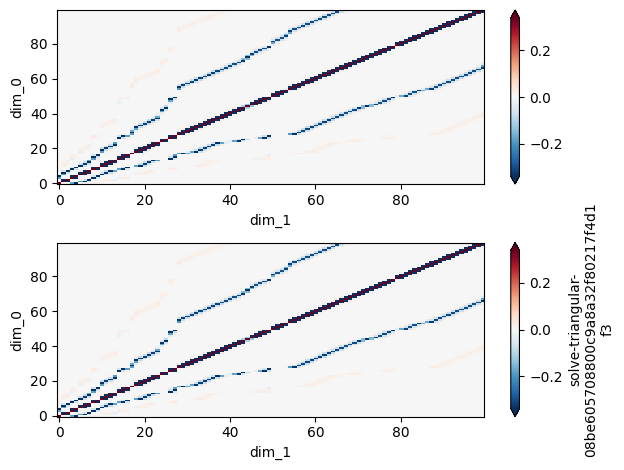

2022-11-25 15:45:31,282 - bokeh.core.property.validation - ERROR - 'transfer-solve-triangular'
Traceback (most recent call last):
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/utils.py", line 748, in wrapper
    return func(*args, **kwargs)
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/dashboard/components/shared.py", line 295, in update
    ts = metadata["keys"][self.key]
KeyError: 'transfer-solve-triangular'
2022-11-25 15:45:31,282 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fbc46daa770>>, <Task finished name='Task-79537' coro=<ServerSession.with_document_locked() done, defined at /home/pietaril/.local/lib/python3.10/site-packages/bokeh/server/session.py:78> exception=KeyError('transfer-solve-triangular')>)
Traceback (most recent call last):
  File "/home/pietaril/.local/lib/python3.10/site-packages/tornado/iol

In [6]:
import matplotlib.pyplot as plt

iM = xr.DataArray(iM)
real_iM = xr.DataArray(real_iM)

fig, axs = plt.subplots(2, layout = "tight")
iM.plot.imshow(ax=axs[0], robust = True)
real_iM.plot.imshow(ax= axs[1], robust = True)
plt.show()

In [5]:
#Trying out examples from "Embarrassingly parallel Workloads"

#Note: the array needs to be submitted to gmres as numpy, not xarray: hence M = bio_i.values


M = bio_2.data.persist()
n = len(M)
cols = []
exit_codes = []

for i in np.arange(n):
    e_i = np.zeros(n)
    e_i[i] = 1
    inv_col = dask.delayed(gmres)(M, e_i, tol = 1e-8)
    cols.append(inv_col[0])
    exit_codes.append(inv_col[1])

cols = dask.compute(*cols)
exit_codes = dask.compute(*exit_codes)



(5,)
(5,)
(5,)
(5,)
(5,)


In [4]:
cols[0]

array([ 1.42166327e+00,  5.36698020e-10, -1.57083747e-08, -1.76773241e-01,
       -4.11504022e-01,  1.51496261e-10,  1.61222993e-09, -5.83921448e-09,
        2.11283206e-02,  1.32643671e-02, -1.06548298e-11,  5.51374648e-10,
        1.69626038e-09, -1.86755524e-08,  5.23461239e-04,  1.36994123e-03,
       -3.23410238e-04, -3.37216946e-11, -3.30362512e-11, -3.95587578e-11,
        1.47111775e-10,  1.39649108e-09,  2.61089425e-09, -2.52984473e-08,
       -1.23330657e-06, -9.34000437e-06,  3.67475994e-05,  9.61510391e-05,
       -5.90298506e-11, -4.73796073e-11, -1.03470669e-11,  5.38882320e-12,
       -1.40395338e-11, -1.69964062e-11,  5.00370829e-11,  3.52115577e-10,
        1.85924023e-09,  2.29627205e-09, -7.57020396e-09, -2.24303709e-08,
       -2.94110074e-08,  9.54384453e-08,  7.08305909e-07,  3.25670949e-08,
       -1.11013244e-05, -1.77851796e-05, -8.21611222e-06,  4.95345670e-06,
        1.47633021e-05,  3.90561347e-06, -4.41997595e-11, -6.23010213e-11,
       -6.39051536e-11, -

In [6]:
#Note: for some reason cols = dask.compute(cols) produces a tuple that comprises of a single list:
#That's why we need the double index cols[0][i]

for i in range(41):
    print(np.allclose(cols[0][i], invM_real[:,i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Another attempt with Dask delayed, this time with the decorator
------------------------------------------------------------------
* the one with just numpy arrays below (dask arrays commented out) was extremely slow. need to do something about it
* When I read the matrix as a dask.array and persisted before the loop, I could see in the task stream that the workers kept opening the dataset throughout the computation until it crashed. 

In [19]:
@delayed
def columnwise_inv(filepath: str):
    ds = xr.open_dataset(filepath, chunks='auto')
    M = ds["covariance_bio"].data.persist()
    n = len(M)
    e_base = da.zeros(n, chunks= 'auto')
    cols = []

    # for loop for computing the individual columns
    for i in np.arange(n):
        e_i = e_base
        e_i[i] = 1
        inv_col_i = gmres(M, e_i, tol = 1e-8)
        cols.append(inv_col_i)
    
    #inv_M = np.column_stack(cols)
    
    #return inv_M
    return cols



In [20]:
iM = columnwise_inv("data/regions_verify_202104_cov.nc")

In [21]:
dask.compute(*iM)

TypeError: Delayed objects of unspecified length are not iterable

Dask arrays
-------------

NOTE: From documentation: Dask Array doesn’t implement operations like tolist that would be very inefficient for larger datasets. 
Likewise, it is very inefficient to iterate over a Dask array with for loops

Reading the netcdf into dask arrays with chunks
-------------------------------------------------

* Chunking seems to default in row-wise slicing. To make it columnwise, specify: chunks=(-1, k), where k is the number of columns per chunk
* Idea: maybe we actually want to chunk the eye matrix - that is the one that changes in each call to gmres. Also here it doesn't
matter if it takes the rows instead of columns as they are the same
* Started reviewing Xarray's user guide for working with Dask and Xarray. Trying to figure out if the apply_ufunc or map_blocks -functions could be useful

In [10]:

eye = np.eye(6858)
eye = da.from_array(eye, chunks= (-1, 900))
eye

dask.array<array, shape=(6858, 6858), dtype=float64, chunksize=(6858, 900), chunktype=numpy.ndarray>

Apply_along_axis 
----------------

In [10]:
M = M = bio_2[:1000,:1000].values
n = len(M)
eye = da.eye(n, dtype = float)

gmres1d = lambda x: gmres(M, x)[0]



inv_M = da.apply_along_axis(gmres1d, 1, eye, dtype=float, shape=(n,))


SyntaxError: invalid syntax (1491724807.py, line 7)

In [8]:
inv_M

dask.array<lambda-along-axis, shape=(1000, 1000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [9]:
inv_M.compute()

array([[ 1.42166327e+00, -1.34508530e-08, -2.80250391e-08, ...,
        -2.02705694e-18,  3.90905530e-18, -8.96873053e-19],
       [-1.99142280e-10,  1.58768727e+00, -4.75908017e-01, ...,
        -8.53604299e-17, -6.32811732e-18,  3.09005273e-17],
       [-1.65655282e-08, -4.75907436e-01,  1.56578721e+00, ...,
         8.81856829e-17, -2.02457703e-17, -2.72918574e-17],
       ...,
       [-1.98329098e-18, -8.44579420e-17,  8.91030813e-17, ...,
         1.89348666e+00, -7.11113214e-01, -6.99329835e-06],
       [ 3.94780139e-18, -5.67973214e-18, -1.96859905e-17, ...,
        -7.11113726e-01,  1.89348198e+00, -7.11119289e-01],
       [-9.35110693e-19,  3.03351709e-17, -2.78004391e-17, ...,
        -6.95130137e-06, -7.11118722e-01,  1.57174330e+00]])

In [22]:
cols[0][0]

[array([ 1.25426569e+00, -3.52374850e-02, -6.35396420e-02, -1.01722351e-03,
        -1.00184492e-03, -2.85938105e-05,  6.91899580e-06,  1.12820986e-08,
         2.22862241e-11,  1.38580188e-12,  9.67084860e-10,  1.03813559e-10,
         1.61003724e-11,  2.79279604e-14, -3.45878263e-05, -8.87050416e-04,
         1.08150089e-09,  3.02299850e-08, -1.07141628e-07,  7.84269013e-10,
        -1.32032696e-09, -1.65843816e-11, -1.73914270e-05,  2.69015686e-07,
         3.61151731e-08,  3.70048720e-08,  4.04807298e-07, -2.86541422e-07,
        -1.10214792e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]),
 array([-3.52374850e-02,  1.25182439e+00, -1.33715847e-02, -2.83921396e-02,
        -1.63288210e-04, -1.69204337e-04, -1.01739332e-05,  4.65606710e-08,
        -5.20358294e-11,  4.97998436e-12, -6.52625275e-08,  4

Futures & client.map
--------------------

* So far this one has worked best: managed to run it with 1000 x 1000 part of bio_2
* still pretty slow though
* Kernel crashed with 2000 x 2000 matrix
* One problem is passing M to map because we don't want to repeat it. Solution so far is the function partial but not sure if it works as it should as sometimes I get a result with the wrong shape back.

In [3]:
M = bio_2.values
M = M[:2000,:2000]

def invert_col(A, idx: int):
    n = len(A)
    e_i = np.zeros(n)
    e_i[idx] = 1
    inverted = gmres(A, e_i, tol = 1e-10)
    return inverted[0]

invert_col_frozen = partial(invert_col, M)


futures = client.map(invert_col_frozen, np.arange(len(M)))

: 

: 

In [29]:
results = client.gather(futures)
#inv_with_futures = np.stack(results, axis = 1)


In [9]:

gmres_frozen = partial(gmres, A = M)
eye = np.eye(len(M))
e_i_s = [row for row in eye]
futures = client.map(gmres_frozen, e_i_s)

2022-10-26 00:20:28,268 - distributed.worker - WARNING - Compute Failed
Key:       gmres-b40bd815120dbe995af6feef098c279b
Function:  gmres
args:      (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
kwargs:    {}
Exception: 'TypeError("gmres() got multiple values for argument \'A\'")'

2022-10-26 00:20:28,268 - distributed.worker - WARNING - Compute Failed
Key:       gmres-1df6b47d33af5523a2b1f2d8e5e73039
Function:  gmres
args:      (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
kwargs:    {}
Exception: 'TypeError("gmres() got multiple values for argument \'A\'")'

2022-10-26 00:20:28,268 - distributed.worker - WARNING - Compute Failed
Key:       gmres-b38eeb828020c0cdf88dc38f27ccd4d7
Function:  gmres
args:    

"Use larger tasks" -implementation
-----------------------------------
* Trying to do what is done here https://distributed.dask.org/en/stable/efficiency.html under "use larger tasks"

In [ ]:
M = bio_2.values
n = len(M)

eye = da.eye(n).rechunk(chunks = (-1, 900))

blocks = eye.blocks.ravel()

def gmres_many(M, block):
    return [gmres(M, c) for c in block]

#scipy gmres only works with b of shape = (N,) or (N,1)

Trying to solve Ax = b with x that consists of several columns
--------------------------------------------------------------

Note: gmres only works when x.shape = (N,) or (N,1)

In [36]:
M = bio_2.values
n = len(M)

# identity matrix partitioned columnwise into chunks
eye = np.eye(n)

blocks = np.array_split(eye, 8)


inv_blocks = []

for b in blocks:
    print(b)
    #inv_block = npsolve(M, b)
#     inv_blocks.append(inv_block)

# iM = da.concatenate(inv_blocks, axis = 1)



[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

In [8]:
M_inv = np.stack(results, axis = 1)
print(M_inv)
print(M_inv.shape)

[[array([ 1.42166327e+00, -1.34508530e-08, -2.80250391e-08, -1.76773559e-01,
         -4.11503880e-01, -2.33237749e-08, -2.53968809e-08, -2.84447636e-08,
          2.11290536e-02,  1.32636162e-02, -4.02160984e-08, -4.28033641e-08,
         -3.29807370e-08, -4.10332531e-08,  5.27138813e-04,  1.36026088e-03,
         -3.16536841e-04, -6.46103982e-09, -4.53955659e-08, -6.18512572e-08,
         -6.20226952e-08, -4.46805573e-08, -2.61072573e-08, -5.16243421e-08,
         -1.22769970e-06, -9.35344916e-06,  3.76812432e-05,  9.83156266e-05,
         -1.31522798e-08, -1.23928072e-08, -1.87888694e-08, -3.76912324e-08,
         -6.54057318e-08, -8.61516639e-08, -8.29998385e-08, -5.59191868e-08,
         -2.94281393e-08, -3.66591966e-08, -8.33968553e-08, -1.15120846e-07,
         -7.84008788e-08,  1.05969522e-07,  6.96691579e-07, -5.52706764e-08,
         -1.10268237e-05, -1.87114959e-05, -7.05103501e-06,  5.75114868e-06,
          1.05652479e-05,  2.80567519e-06,  6.26861524e-09,  1.71683136e-09,

/usr/lib/python3/dist-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


In [11]:
def invert_col(A, idx: int):
    n = len(A)
    e_i = np.zeros(n)
    e_i[idx] = 1
    inverted = gmres(A, e_i, tol = 1e-10)
    return inverted[0]


n = len(M)
inverted_cols = []
big_future = client.scatter(M)
for i in np.arange(n):
   invcol = client.submit(invert_col, big_future, i)
   inverted_cols.append(invcol)


2022-10-26 00:26:16,812 - bokeh.application.handlers.function - ERROR - '<' not supported between instances of 'NoneType' and 'tuple'
Traceback (most recent call last):
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/utils.py", line 748, in wrapper
    return func(*args, **kwargs)
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/dashboard/components/scheduler.py", line 4202, in graph_doc
    graph = TaskGraph(scheduler, sizing_mode="stretch_both")
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/dashboard/components/scheduler.py", line 2253, in __init__
    self.layout = GraphLayout(scheduler)
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/diagnostics/graph_layout.py", line 41, in __init__
    self.update_graph(
  File "/home/pietaril/.local/lib/python3.10/site-packages/distributed/diagnostics/graph_layout.py", line 51, in update_graph
    stack = sorted(tasks, key=lambda k: priority.get(k, 0), r

In [16]:
print(Minv)
print(exitCodes)

[[ 1.25426569e+00 -3.52374850e-02 -6.35396420e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.52374850e-02  1.25182439e+00 -1.33715847e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.35396420e-02 -1.33715847e-02  1.26289885e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.00079700e+00
  -6.31019841e-02  4.64396874e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.31019841e-02
   5.00079671e+00 -2.09457564e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.64313226e-07
  -2.09457041e-05  5.00489954e+00]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
print(np.allclose(invM, Minv))

True


Version where several columns form a block
------------------------------------------

In [ ]:
M = bio_2.data
n = len(M)
eye = np

In [8]:
#from https://github.com/dask/dask/issues/7589
#has a similar idea that you repeat a function on different chunks, 
# maybe I should formulate my code in a similar fashion?

import dask.array as da
import numpy as np
import dask

np.random.seed(42)

x = da.ones((20, 10), chunks=(10, 10))


@dask.delayed
def foo(a):
    size = np.random.randint(1,10)
    return np.random.randint(1,10, size=(2, size))

blocks = x.to_delayed().ravel()
results = [da.from_delayed(foo(b), shape=(2, np.nan), dtype=np.int64) for b in blocks]
arr = da.concatenate(results, axis=1, allow_unknown_chunksizes=True)
arr.compute()


[[Delayed(('ones_like-2bffc6efca707b4871610a2fa65443e1', 0, 0))]
 [Delayed(('ones_like-2bffc6efca707b4871610a2fa65443e1', 1, 0))]]


array([[6, 5, 2, 1, 5, 6, 1, 5, 4, 4, 9, 9],
       [2, 9, 7, 4, 7, 9, 7, 2, 2, 3, 5, 2]])